# Customer Segmentation
I will be using the online retail dataset from the UCI Machine Learning Repository for exploratory data analysis and customer segmentation using RFM Analysis K-Means Clustering.

This notebook covers:
Data Cleaning

Exploartory Data Analysis

RFM Analysis

K-Means Clustering

In [2]:

import pandas as pd
import numpy as np
import warnings

#visualizations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

warnings.filterwarnings('ignore')


df=pd.read_excel("Online Retail.xlsx")

# 1. Data Cleaning

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom



Attribute Information:

InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
Description: Product (item) name. Nominal.
Quantity: The quantities of each product (item) per transaction. Numeric.
InvoiceDate: Invice Date and time. Numeric, the day and time when each transaction was generated.
UnitPrice: Unit price. Numeric, Product price per unit in sterling.
CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
Country: Country name. Nominal, the name of the country where each customer resides

In [4]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB



Our dataset is composed of 8 columns and 541,909 rows. Let's explore the different columns and then check for null values and decide how we want to deal with them.

In [5]:
#Check for Null Values

In [6]:
np.sum(df.isnull())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:

print("Percentage of customers missing: ", round(df['CustomerID'].isnull().sum() * 100 / len(df),2),"%" )

Percentage of customers missing:  24.93 %



a. We are missing values in the CustomerID and Description columns.
b. Since 25% of the customer ID's are missing, we will create and fill a new column that has a 1 when customer ID is null and a 0 when it is not.
c. We will investigate the records where the CustomerID field is null to determine whether to erase those rows or fill in the missing values.
d. Since we won't be doing analysis on the descriptions of the orders, we can leave the null values as is

In [8]:
df['CustomerID_is_null'] = [1 if i == True else 0 for i in df.CustomerID.isnull()]

In [9]:

#Create a new dateframe of only orders with missing CustomerID values
df1 = df[df['CustomerID_is_null'] == 1]

In [10]:

df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135080 entries, 622 to 541540
Data columns (total 9 columns):
InvoiceNo             135080 non-null object
StockCode             135080 non-null object
Description           133626 non-null object
Quantity              135080 non-null int64
InvoiceDate           135080 non-null datetime64[ns]
UnitPrice             135080 non-null float64
CustomerID            0 non-null float64
Country               135080 non-null object
CustomerID_is_null    135080 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 10.3+ MB


In [11]:
df1.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom,1
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom,1
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,1
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom,1
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom,1
1447,536544,21790,VINTAGE SNAP CARDS,9,2010-12-01 14:32:00,1.66,NaN,United Kingdom,1
1448,536544,21791,VINTAGE HEADS AND TAILS CARD GAME,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom,1
1449,536544,21801,CHRISTMAS TREE DECORATION WITH BELL,10,2010-12-01 14:32:00,0.43,NaN,United Kingdom,1
1450,536544,21802,CHRISTMAS TREE HEART DECORATION,9,2010-12-01 14:32:00,0.43,NaN,United Kingdom,1
1451,536544,21803,CHRISTMAS TREE STAR DECORATION,11,2010-12-01 14:32:00,0.43,NaN,United Kingdom,1


I noticed that there are usually several products being bought per order where each unique InvoiceNo is a sperate order.


In [12]:

print("Number of orders in df1:", df1['InvoiceNo'].nunique())
print("Avg. number of products per order in df1: ", round(df1['StockCode'].count() / df1['InvoiceNo'].nunique(),2) )
print("Avg. number of products per order in df: ",  round(df['StockCode'].count() / df['InvoiceNo'].nunique(),2) )

Number of orders in df1: 3710
Avg. number of products per order in df1:  36.41
Avg. number of products per order in df:  20.92



Since the customer ID's are missing, lets assume these orders were not made by the customers already in the data set because those customers already have ID's. We also don't want to assign these orders to those customers because this would alter the insights we draw from the data. Instead of dropping the null CustomerID values, let's assign those rows a unique customer ID per order. This will act as a new customer for each unique order.

How should we assign the new customer ID's?

Using the values in the InvoiceNo column would be the most straightfoward approach. We will create a new customer ID column called NewID with the invoice numbers filling in for the missing values. Then we will add the number of unique orders in df1 and to number of unique values in CustomerID and see if it equals the number of unique values in NewID. This will check if any of the new values match the existing values in the column and make sure we didn't add more orders to an existing customer.

In [13]:

df['NewID'] = df['CustomerID']
df.loc[df['CustomerID_is_null'] == 1, ['NewID']] = df['InvoiceNo']

#drop CustomerID column since it isn't need anymore
#df = df.drop('CustomerID', 1)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewID
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,17850
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,17850
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,17850
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,17850
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,17850


In [14]:

df.info()# Customers by country

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 10 columns):
InvoiceNo             541909 non-null object
StockCode             541909 non-null object
Description           540455 non-null object
Quantity              541909 non-null int64
InvoiceDate           541909 non-null datetime64[ns]
UnitPrice             541909 non-null float64
CustomerID            406829 non-null float64
Country               541909 non-null object
CustomerID_is_null    541909 non-null int64
NewID                 541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 41.3+ MB



Notice that NewID doesn't have any missing values, but the column includes object data types. As mentioned in the description of the dataset, if the invoice number starts with the letter "C", it means it the order was cancelled. All of the data types in the new customer ID column need to be numeric, so we need to first remove any "C" characters from the column.

In [15]:
#Remove all non digits from column NewID
df['NewID'] = df['NewID'].astype(str).str.replace('\D+', '')

#Convert to integer
df['NewID'] = pd.to_numeric(df['NewID'])

#Check if the 'C' character was removed in the NewID column
df[df['NewID']== 580605]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewID
524602,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,NaN,United Kingdom,1,580605


In [16]:
Num_CustomerID = df['CustomerID'].nunique()
Num_df1_InvoiceNo = df1['InvoiceNo'].nunique()
Num_NewID = df['NewID'].nunique()
print("Number of Customers:", df['CustomerID'].nunique())
print("Number of Orders in df1:", df1['InvoiceNo'].nunique())
print("Number of Customers + Number of Orders in df1:", Num_CustomerID + Num_df1_InvoiceNo)
print("Number of New ID's:", df['NewID'].nunique())

Number of Customers: 4372
Number of Orders in df1: 3710
Number of Customers + Number of Orders in df1: 8082
Number of New ID's: 8082


Since both values equal 8082, we know all the different orders that didn't have a customer ID got assigned unique NewID.

# 2. Exploratory Data Analysis

Now that our data set is clean, let's take a closer look at the numberic columns, specifically Quantity and UnitPrice.

In [17]:
df.describe()

,Quantity,UnitPrice,CustomerID,CustomerID_is_null,NewID
count,541909.000000,541909.000000,406829.000000,541909.000000,541909.000000
mean,9.552250,4.611114,15287.690570,0.249267,253869.471330
std,218.081158,96.759853,1713.600303,0.432589,176036.804611
min,-80995.000000,-11062.060000,12346.000000,0.000000,123460.000000
25%,1.000000,1.250000,13953.000000,0.000000,143670.000000
50%,3.000000,2.080000,15152.000000,0.000000,162490.000000
75%,10.000000,4.130000,16791.000000,0.000000,182830.000000
max,80995.000000,38970.000000,18287.000000,1.000000,581498.000000


Notice that there are negative values in the Quantity and UnitPrice columns. I am assuming these are orders that were cancelled and items that were returned, but lets make sure.

Negative Values


As mentioned above, if the invoice number starts with the letter "C", it means it the order was cancelled.

In [18]:
cancelled_orders = df[df['InvoiceNo'].astype(str).str.contains('C')]
cancelled_orders.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewID
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,0,145270
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom,0,153110
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom,0,175480
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,0,175480
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom,0,175480


In [19]:

cancelled_orders[cancelled_orders['Quantity']>0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewID


Since nothing came back when we filtered the cancelled orders by Quantity > 0, this confirms that the negative values mean the order was cancelled.

How many orders were cancelled?

In [20]:

#Calculate the percentage of cancellations by dividing the cancelled orders by the total orders
total_orders = df['InvoiceNo'].nunique()
number_cancelled = len(cancelled_orders)
print('Percentage of orders cancelled: {:.2f}% '.format(number_cancelled / total_orders * 100))

Percentage of orders cancelled: 35.86% 


9288 or about 36% of the orders were cancelled. Looking deeper into why these orders were cancelled may prevent future cancellations.

Now let's find out what a negative UnitPrice means.

In [21]:
df[df['UnitPrice'] < 0]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewID
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,1,563186
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,1,563187



The description of "Adjust bad debt" tells us that this is an adjustment for a customer with insufficient funds or an allowance for a customer who never paid for the order.

# Exploring the Orders
a. What's the average number of orders per customer?

In [22]:
#Find the unique number of InvoiceNo  per customer
groupby_customers = pd.DataFrame(df.groupby('NewID')['InvoiceNo'].nunique())
groupby_customers.head()

,InvoiceNo
NewID,
123460,2
123470,7
123480,4
123490,1
123500,1


In [23]:

groupby_customers.describe()

,InvoiceNo
count,8082.000000
mean,3.204652
std,7.162265
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,248.000000


The average number of orders per customer is 3.

We found in descriptive statistics above that customers buy an average quantity of about 10 per product. Are there some products that are extremely popular? What's the distribution of the number of items the customers buy?

b. What's the average number of unqiue items per order and per customer?

In [24]:

groupby_invoice = pd.DataFrame(df.groupby('InvoiceNo')['StockCode'].nunique())
groupby_invoice.columns = ['Number of Items per Order']
groupby_invoice.head()

,Number of Items per Order
InvoiceNo,
536365,7
536366,2
536367,12
536368,4
536369,1


In [25]:
groupby_invoice.describe()

,Number of Items per Order
count,25900.000000
mean,20.510618
std,42.500488
min,1.000000
25%,2.000000
50%,10.000000
75%,23.000000
max,1110.000000


Let's see how this compares to the number of unique products per customer.

In [26]:
groupby_ID = pd.DataFrame(df.groupby('NewID')['StockCode'].nunique())
groupby_ID.columns = ['Number of Items per Customer']
groupby_ID.head()

,Number of Items per Customer
NewID,
123460,1
123470,103
123480,22
123490,73
123500,17


In [27]:

groupby_ID.describe()

,Number of Items per Customer
count,8082.000000
mean,49.759837
std,91.220932
min,1.000000
25%,1.000000
50%,17.000000
75%,58.000000
max,1794.000000


# Customers by Country

In [28]:
df['Total_Cost'] = df['Quantity'] * df['UnitPrice']

In [29]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CustomerID_is_null,NewID,Total_Cost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,178500,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,178500,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,178500,20.34



What's the total revenue per country?

Let's look at the number of customers by country to get an idea of which countries have the most orders

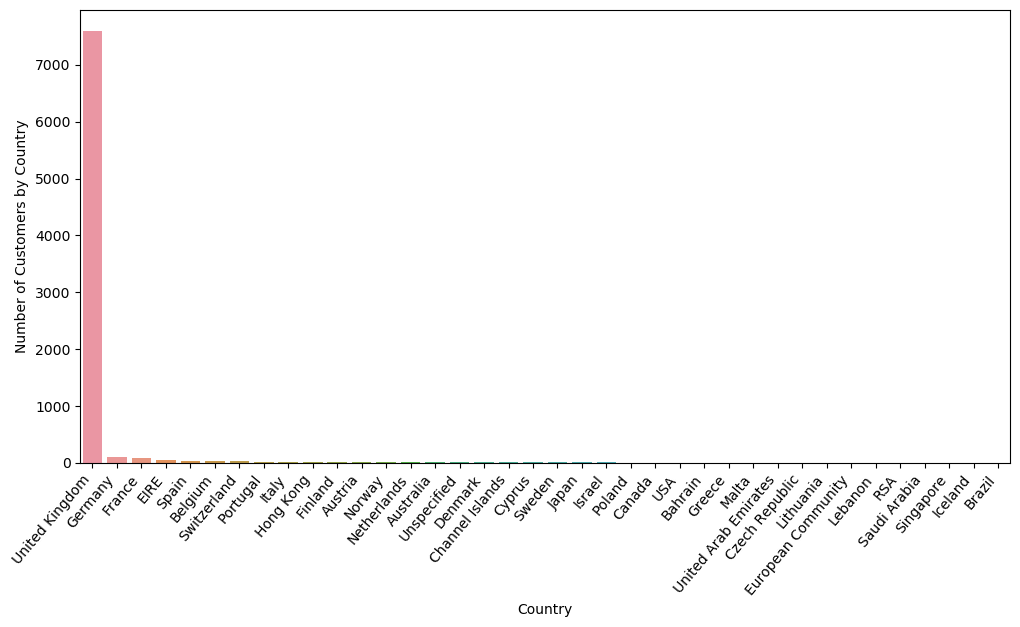

In [30]:

country_df = pd.DataFrame(df.groupby('Country')['NewID'].nunique())
country_df.columns = ['Number of Customers by Country']
country_df.sort_values('Number of Customers by Country', inplace=True, ascending=False)
fig, ax = plt.subplots(figsize=(12,6),dpi=100)
ax=sns.barplot(x=country_df.index, y=country_df['Number of Customers by Country'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=50, ha="right")
plt.show()

The United Kingdom has significantly more customers than the other countries in our data set, so their total cost should look similar.

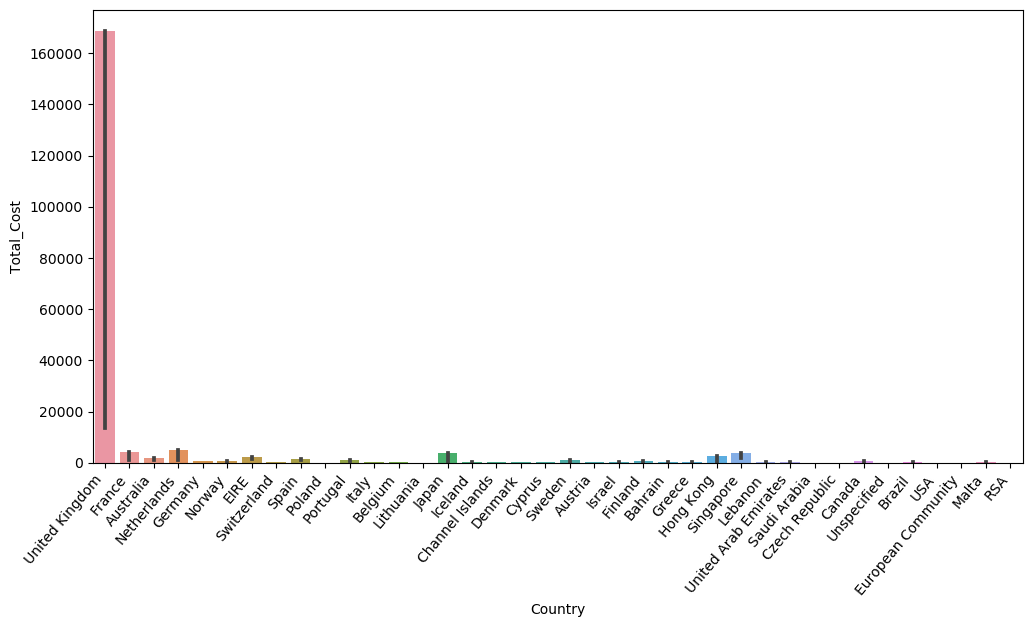

In [31]:
fig1, ax1 = plt.subplots(figsize=(12,6),dpi=100)
ax1=sns.barplot(x='Country', y='Total_Cost', data=df, estimator=max, ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=50, ha="right")
plt.show()


The UK not only has the most sales revenue, but also the most customers. Since the majority of this data set contains orders from the UK, we can explore the UK market further by finding out what products the customers buy together and any other buying behaviors to improve our sales and targeting strategy.

# Exploring the UK Market

In [32]:
df_uk = df[df['Country']=='United Kingdom']
df_uk.describe()

,Quantity,UnitPrice,CustomerID,CustomerID_is_null,NewID,Total_Cost
count,495478.000000,495478.000000,361878.000000,495478.000000,495478.000000,495478.000000
mean,8.605486,4.532422,15547.871368,0.269639,264016.667176,16.525065
std,227.588756,99.315438,1594.402590,0.443772,179302.718367,394.839116
min,-80995.000000,-11062.060000,12346.000000,0.000000,123460.000000,-168469.600000
25%,1.000000,1.250000,14194.000000,0.000000,146390.000000,3.290000
50%,3.000000,2.100000,15514.000000,0.000000,166390.000000,8.290000
75%,10.000000,4.130000,16931.000000,1.000000,538566.000000,16.630000
max,80995.000000,38970.000000,18287.000000,1.000000,581498.000000,168469.600000


In [33]:
print("Percentage of customers from the UK: ", round(df_uk['NewID'].nunique() * 100 / df['NewID'].nunique(),2),"%" )
print("Number of transactions: ", df_uk['InvoiceNo'].nunique())
print("Number of products Bought: ", df_uk['StockCode'].nunique())
print("Number of customers:", df_uk['NewID'].nunique())

Percentage of customers from the UK:  93.88 %
Number of transactions:  23494
Number of products Bought:  4065
Number of customers: 7587


#What are the most popular products that are bought in the UK?

In [34]:
uk_product = df_uk.groupby(['StockCode','Description'],as_index= False)['Quantity'].sum().sort_values(by='Quantity', ascending=False)
uk_product.head(10)

,StockCode,Description,Quantity
3154,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,48326
4340,85099B,JUMBO BAG RED RETROSPOT,43167
1237,22197,POPCORN HOLDER,34365
3274,84879,ASSORTED COLOUR BIRD ORNAMENT,33679
4353,85123A,WHITE HANGING HEART T-LIGHT HOLDER,32901
1677,22616,PACK OF 12 LONDON TISSUES,25307
437,21212,PACK OF 72 RETROSPOT CAKE CASES,24702
1216,22178,VICTORIAN GLASS HANGING T-LIGHT,23242
41,17003,BROCADE RING PURSE,22801
11,15036,ASSORTED COLOURS SILK FAN,20322


We will continue analyzing the UK transactions with customer segmentation.

# 3. RFM Analysis

In the age of the internet and e-commerce, companies that do not expand their businesses online or utilize digital tools to reach their customers will run into issues like scalability and a lack of digital precsence. An important marketing strategy e-commerce businesses use for analyzing and predicting customer value is customer segmentation. Customer data is used to sort customers into group based on their behaviors and preferences.

Our goal in this Notebook is to cluster the customers in our data set to:

Recognize who are our most valuable customers
Increase revenue
Increase customer retention
Learn more about the trends and behaviors of our customers
Define customers that are at risk
We will start with RFM Analysis and then compliment our findings with predictive analysis using K-Means Clustering Algorithms.

RFM (Recency, Frequency, Monetary) Analysis is a customer segmentation technique for analyzing customer value based on past buying behavior.

It answers the following questions:

Who are our best customers?
Who has the potential to be converted into more profitable customers?
Which customers do we need to retain?
Which group of customers is most likely to respond to our marketing campaign?

In [35]:
import time
import datetime as dt
from pandas.plotting import scatter_matrix

#Predictive models
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_samples, silhouette_score

In [36]:

#Check the shape of the data set
df_uk.shape
#Let's remove the cancelled orders so the negative values don't affect our analysis.

(495478, 11)

In [37]:
df_uk = df_uk[df_uk['Quantity']>0]
df_uk.shape

(486286, 11)


Even though we went through the trouble of creating a new column for customer ID's without any null values, these fake customer ID's would skew our analysis, especially looking at frequency. Because all these "customers" only transacted with us onece, it would affect the ranking of real customers that transacted with us multiple times.

In [38]:
#remove rows where customerID are NA
df_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
df_uk.shape

(354345, 11)

In [39]:
print("Number of transactions: ", df_uk['InvoiceNo'].nunique())
print("Number of products bought: ",df_uk['StockCode'].nunique())
print("Number of customers:", df_uk['CustomerID'].nunique() )
print("Percentage of customers NA: ", round(df_uk['CustomerID'].isnull().sum() * 100 / len(df),2),"%" )

Number of transactions:  16649
Number of products bought:  3645
Number of customers: 3921
Percentage of customers NA:  0.0 %


# a. Recency: Days since last purchase

To calculate recency, we need to choose a date as a point of reference to evaluate how many days ago was the customer's last purchase

In [40]:

df_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')


Timestamp('2011-12-09 12:49:00')
The most recent date is 12/9/2011 so we will use it as the reference.

In [41]:

now = dt.date(2011,12,9)

In [42]:

#Create a new column called Date which contains the invoice date without the timestamp
df_uk['Date'] = df_uk['InvoiceDate'].dt.date

In [43]:
#Group by NewID and check the last date of purchase
df_recency = df_uk.groupby(by='CustomerID', as_index=False)['Date'].max()
df_recency.columns = ['CustomerID', 'Last_Purchase_Date']
df_recency.head()

,CustomerID,Last_Purchase_Date
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [44]:
#Calculate the days since last purchase
df_recency['Recency'] = df_recency['Last_Purchase_Date'].apply(lambda x: (now - x).days)
df_recency.head()

,CustomerID,Last_Purchase_Date,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [45]:
#Drop Last_Purchase_Date since we don't need it anymore
df_recency.drop('Last_Purchase_Date', axis=1, inplace=True)

# b. Frequency: Number of purchases
To calculate how many times a customer purchased something, we need to count how many invoices each customer has.

In [46]:

#Make a copy of df_uk and drop duplicates
df_uk_copy = df_uk
df_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

#Calculate the frequency of purchases
df_frequency = df_uk_copy.groupby(by='CustomerID', as_index=False)['InvoiceNo'].count()
df_frequency.columns = ['CustomerID','Frequency']
df_frequency.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,11
2,12748.0,210
3,12749.0,5
4,12820.0,4


# c. Monetary: Total amount of money spent

The monetary value is calculated by adding together the cost of the customers' purchases. We already did this when we created the column Total_Cost

In [47]:

df_monetary = df_uk.groupby(by='CustomerID',as_index=False).agg({'Total_Cost': 'sum'})
df_monetary.columns = ['CustomerID', 'Monetary']
df_monetary.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,689.49
2,12748.0,3841.31
3,12749.0,98.35
4,12820.0,58.20


# Create RFM Table

In [48]:
#Merge the recency and frequency dataframes
df_merge = df_recency.merge(df_frequency, on='CustomerID')
df_merge.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,11
2,12748.0,0,210
3,12749.0,3,5
4,12820.0,3,4


In [49]:
#Merge with monetary dataframe
df_rfm = df_merge.merge(df_monetary,on='CustomerID')
df_rfm.set_index('CustomerID',inplace=True)
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,11,689.49
12748.0,0,210,3841.31
12749.0,3,5,98.35
12820.0,3,4,58.20


If we look at CustomerID: 123460, his or her last purchase was 325 days ago (from reference date), they only bought from us one time, and they spent a total of $77,183.60

# Customer Segmentation with RFM Model

RFM Scoring
The simplest way to create customer segments from an RFM model is by using Quartiles. We will assign a score from 1 to 4 to each category (Recency, Frequency, and Monetary) with 4 being the highest/best value. The final RFM score is calculated by combining the individual RFM values.

Note: Data can be assigned into more groups for better granularity, but we will use 4 in this case

In [50]:
quantiles = df_rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,17.0,1.0,17.7
0.50,50.0,2.0,45.4
0.75,142.0,5.0,124.5


Creating the RFM Segmentation Table

We will create two segmentation classes since high recency (more days since last purchase) is bad, while high frequency and montary value is good.

In [51]:
#Arguments (x= value, p = recency, monetary_value, frequency, d = quartiles dict)
def Rscore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

#Arguments (x= value, p = recency, monetary_value, frequency, d = quartiles dict)
def FMscore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [52]:
#Create RFM segmentation table
rfm_segmentation = df_rfm
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(Rscore, args=('Recency',quantiles))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMscore, args=('Frequency',quantiles))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMscore, args=('Monetary',quantiles))

In [53]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,
12346.0,325,1,77183.60,1,1,4
12747.0,2,11,689.49,4,4,4
12748.0,0,210,3841.31,4,4,4
12749.0,3,5,98.35,4,3,3
12820.0,3,4,58.20,4,3,3



Now that we scored each customer, we'll combine the scores for segmentation.

In [54]:

rfm_segmentation['RFM_Score'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Score
CustomerID,,,,,,,
12346.0,325,1,77183.60,1,1,4,114
12747.0,2,11,689.49,4,4,4,444
12748.0,0,210,3841.31,4,4,4,444
12749.0,3,5,98.35,4,3,3,433
12820.0,3,4,58.20,4,3,3,433


A score of 4 represents the customer being in the 75th percentile for that category. Let's see who are our best customers.

In [55]:

rfm_segmentation[rfm_segmentation['RFM_Score']=='444'].head(10)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFM_Score
CustomerID,,,,,,,
12747.0,2,11,689.49,4,4,4,444
12748.0,0,210,3841.31,4,4,4,444
12828.0,2,6,154.80,4,4,4,444
12839.0,2,14,233.91,4,4,4,444
12841.0,4,25,328.74,4,4,4,444
12877.0,3,12,365.79,4,4,4,444
12901.0,8,28,9230.45,4,4,4,444
12919.0,8,6,267.40,4,4,4,444
12921.0,9,37,1014.11,4,4,4,444


 scores 1 as the highest and 4 as the lowest

How many customers do we have in each segment?

In [56]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFM_Score']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFM_Score']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='111']))

Best Customers:  370
Loyal Customers:  791
Big Spenders:  980
Almost Lost:  65
Lost Customers:  11
Lost Cheap Customers:  377


Now we can filter our dataset by each category and target each group differently.

For Example:

We could reward our Best Customers and Loyal Customers or create a "Refer a Friend" promotional offer targeted for them.

For the Almost Lost customers, we could aggressively market towards them with great deals so we don't lose them forever.

Choosing a Predictive Model
Now that we have our customers segmented into 6 different categories, we can gain further insight into customer behavior by using predictive models in conjuction with out RFM model.

Possible algorithms include Logistic Regression, K-means Clustering, and K-nearest Neighbor. We will go with K-means since we already have our distinct groups determined. K-means has also been widely used for market segmentation and has the advantage of being simple to implement.

# Hopkins Statistics:

The Hopkins statistic, is a statistic which gives a value which indicates the cluster tendency, in other words: how well the data can be clustered.

If the value is between {0.01, ...,0.3}, the data is regularly spaced.

If the value is around 0.5, it is random.

If the value is between {0.7, ..., 0.99}, it has a high tendency to cluster.

In [57]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [58]:
hopkins(rfm_segmentation)

0.999840103140577

# Applying K-Means Clustering on RFM Variables

In [59]:

rfm_data = df_rfm.drop(['R_Quartile','F_Quartile','M_Quartile','RFM_Score'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,11,689.49
12748.0,0,210,3841.31
12749.0,3,5,98.35
12820.0,3,4,58.20


In [60]:
rfm_data.corr()

,Recency,Frequency,Monetary
Recency,1.000000,-0.273779,-0.030123
Frequency,-0.273779,1.000000,0.163225
Monetary,-0.030123,0.163225,1.000000


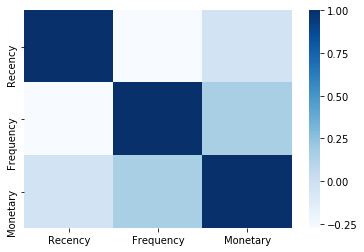

In [72]:

sns.heatmap(rfm_data.corr(),cmap="Blues",fmt="d")


Looking at this heatmap, we see that there is a negative correlation between Recency : Frequency and Recency : Monetary, but there is a positive correlation between Frequency : Monetary

# Data Normalization

In [62]:
rfm_r_log = np.log(rfm_data['Recency']+0.1) #log(0) is undefined
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [63]:

log_data = pd.DataFrame({'Monetary': rfm_m_log, 'Recency': rfm_r_log, 'Frequency': rfm_f_log})

In [64]:
log_data.head()

,Monetary,Recency,Frequency
CustomerID,,,
12346.0,11.253944,5.784133,0.000000
12747.0,6.536097,0.741937,2.397895
12748.0,8.253595,-2.302585,5.347108
12749.0,4.589549,1.131402,1.609438
12820.0,4.065602,1.131402,1.386294


In [65]:
log_data.corr()

,Monetary,Recency,Frequency
Monetary,1.000000,-0.368472,0.716935
Recency,-0.368472,1.000000,-0.573982
Frequency,0.716935,-0.573982,1.000000



Now, Monetary and Frequency are more strongly correlated, so we will use those two variables in our K-Means model.

# K-Means Implementation

For k-means, you have to set k to the number of clusters you want, but figuring out how many clusters is not obvious from the beginning. We will try different cluster numbers and check their silhouette coefficient. The silhouette coefficient for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar).

Note: K-means is sensitive to initializations because they are critical to qualifty of optima found. Thus, we will use smart initialization called k-means++

In [66]:

matrix = log_data.as_matrix()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.38928248344330485
For n_clusters = 3 The average silhouette_score is : 0.3023041937392807
For n_clusters = 4 The average silhouette_score is : 0.3122008042036601
For n_clusters = 5 The average silhouette_score is : 0.29136169284847374
For n_clusters = 6 The average silhouette_score is : 0.29710692475242406
For n_clusters = 7 The average silhouette_score is : 0.2940320824507468
For n_clusters = 8 The average silhouette_score is : 0.288049661337991
For n_clusters = 9 The average silhouette_score is : 0.29055104577357094


The best silhouette score obtained is when there are 2 clusters.

In [67]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)
silhouette_avg = silhouette_score(matrix, clusters_customers)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.389


# Visualize the Clusters

Text(0, 0.5, 'Monetary')

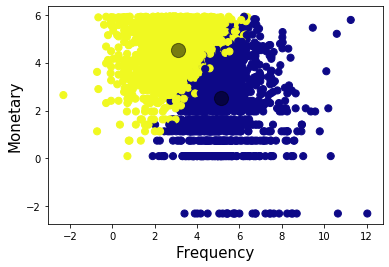

In [68]:
#create a scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='plasma')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel('Frequency', fontsize=15)
plt.ylabel('Monetary', fontsize=15)

The yellow cluster has a centroid at around (3, 4.5) and represents the "low value customers". The dark blue cluster has a centroid at around (5, 2.5) and represents the "high value customers".

In [69]:

# What's the number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['Number Customers']).T

,1,0
Number Customers,2362,1559


# Conclusion


From the figure of clustering, it can be seen that the K-means algorithm has grouped the entire data set into two clusters based on Frequency and Monetary values with the two centroids as (4.5,2.5) and (2.5,4.5). The number of Customers in the first and second clusters are 2362 and 1559 respectively.
From analyzing the clusters with respect to their centroids, it can be seen that the customers who often visits the store spends less as compared to the customers who visits less often to the store.
